# Baseline model – Decision-tree classifier for ECG-based Chagas detection
This notebook builds a single CART decision tree (`sklearn.tree.DecisionTreeClassifier`) as an initial benchmark.

## Environment setup

### Import libraries

In [1]:
import joblib
import os
import sys
import random

import numpy as np
import pandas as pd
from scipy.stats import randint

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    average_precision_score,
    precision_recall_fscore_support,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ParameterGrid

# Reproducibility seed
RANDOM_STATE = 2025
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

### Load preprocessed datasets

In [2]:
# Path to the folder containing preprocessed data
DATA_DIR = '../data/prepared'

# train_full = np.load(f'{DATA_DIR}/train_full_parts0-6.npz')
train = np.load(f'{DATA_DIR}/train_bal_parts0-6_aug.npz')
val = np.load(f'{DATA_DIR}/val_parts0-6.npz')
test = np.load(f'{DATA_DIR}/test_external.npz')

# Extract arrays and labels from the loaded data
#X_train_full, y_train_full = train_full['X'], train_full['y']
X_train, y_train = train['X'], train['y']
X_val, y_val = val['X'], val['y']
X_test, y_test = test['X'], test['y']

# Check array shapes 
print('Train :', X_train.shape,  'Positives:', y_train.sum())
print('Val   :', X_val.shape,    'Positives:', y_val.sum())
print('Test  :', X_test.shape,   'Positives:', y_test.sum())

Train : (17880, 2920, 12) Positives: 4470
Val   : (27873, 2920, 12) Positives: 559
Test  : (23430, 2920, 12) Positives: 1631


## Modeling

### Train baseline decision tree

In [3]:
# Flatten ECGs to 1-D feature vectors
X_train_flat = X_train.reshape(len(X_train), -1)

# Fit decision tree with class weighting
tree = DecisionTreeClassifier(
    max_depth=10,
    class_weight='balanced',
    random_state=42
)
tree.fit(X_train_flat, y_train)

# Save for reuse
# joblib.dump(tree, 'baseline_tree.joblib')
# print('Baseline tree saved to baseline_tree.joblib')

,criterion,'gini'
,splitter,'best'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


In [4]:
# Hyperparameter tuning using GridSearchCV
search = GridSearchCV(
    DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE),
    param_grid={'max_depth': [5, 10, 20, 40],
                'min_samples_split': [2, 5, 10]},
    scoring='roc_auc',
    cv=5,
    n_jobs=1,
)

# Fit the search to the training data
search.fit(X_train_flat, y_train)

tree = search.best_estimator_ 

print('Best parameters    :', search.best_params_)

Best parameters    : {'max_depth': 40, 'min_samples_split': 5}


In [5]:
def report(name, X_split, y_split, plot_cm=True):
    """
    Create a report of the model's performance on the given split.
    Args:
        name (str): Name of the dataset split (e.g., 'Train', 'Validation', 'External test').
        X_split (np.ndarray): Feature matrix for the split.
        y_split (np.ndarray): True labels for the split.
        plot_cm (bool): Whether to plot the confusion matrix.
    Returns:
        Prints the performance metrics and confusion matrix.
    """
    y_prob = tree.predict_proba(X_split)[:, 1]
    y_pred = tree.predict(X_split)
    acc = accuracy_score(y_split, y_pred)
    auroc = roc_auc_score(y_split, y_prob)
    auprc = average_precision_score(y_split, y_prob)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_split, y_pred, average='binary', zero_division=0
    )
    cm = confusion_matrix(y_split, y_pred)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    print(f'{name} metrics')
    print(f'  accuracy     {acc:.3f}')
    print(f'  AUROC        {auroc:.3f}')
    print(f'  AUPRC        {auprc:.3f}')
    print(f'  precision    {prec:.3f}')
    print(f'  recall       {rec:.3f}')
    print(f'  specificity  {specificity:.3f}')
    print(f'  F1           {f1:.3f}\n')

    if plot_cm:
        ConfusionMatrixDisplay(cm, display_labels=['Neg', 'Pos']).plot(cmap='Blues')
        plt.title(f'{name} confusion matrix')
        plt.show()


Train metrics
  accuracy     0.999
  AUROC        1.000
  AUPRC        1.000
  precision    0.995
  recall       1.000
  specificity  0.998
  F1           0.998



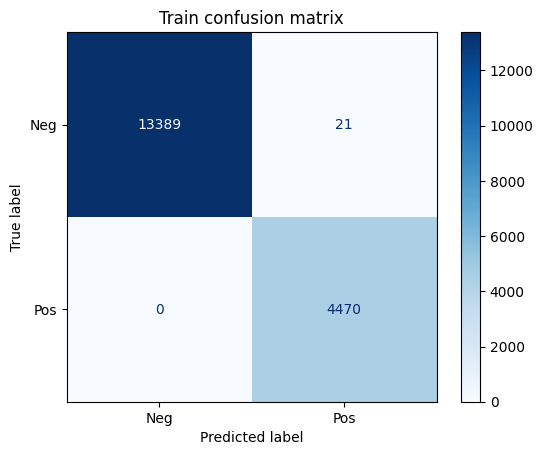

Validation metrics
  accuracy     0.776
  AUROC        0.568
  AUPRC        0.023
  precision    0.033
  recall       0.363
  specificity  0.784
  F1           0.061



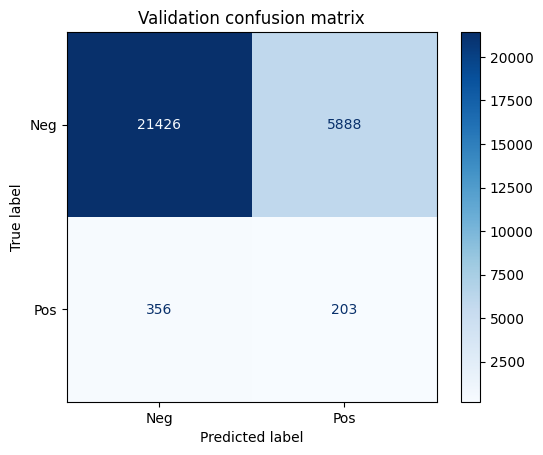

External test metrics
  accuracy     0.725
  AUROC        0.483
  AUPRC        0.067
  precision    0.061
  recall       0.206
  specificity  0.764
  F1           0.094



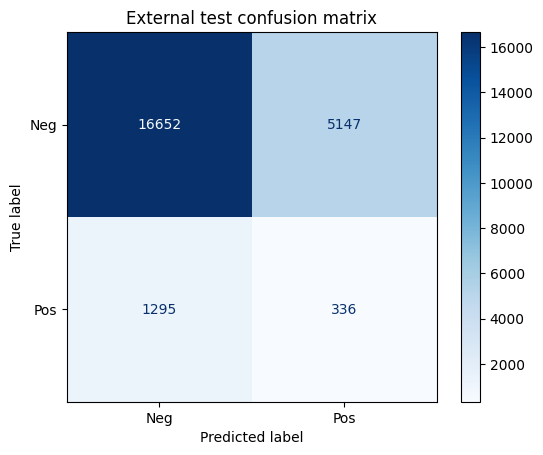

In [6]:
# Flatten datasets for evaluation
X_train_flat = X_train.reshape(len(X_train), -1)
X_val_flat = X_val.reshape(len(X_val), -1)
X_test_flat = X_test.reshape(len(X_test), -1)

# Report performance on train, validation, and external test sets
report('Train', X_train_flat, y_train)
report('Validation', X_val_flat, y_val)
report('External test', X_test_flat, y_test)

In [7]:
# Set parameters for RandomizedSearchCV
param_dist = {'max_depth': [5, 10, 20, None],
              'min_samples_split': randint(2, 11)}

# Initialize RandomizedSearchCV
search = RandomizedSearchCV(
    DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_STATE),
    param_distributions=param_dist,
    n_iter=6,          # eight random combos
    scoring='roc_auc',
    # cv=3, 
    n_jobs=1,
    verbose=2,
)

# Flatten ECGs to 1-D feature vectors
X_train_flat = X_train.reshape(len(X_train), -1)

# Fit the search to the training data
search.fit(X_train_flat, y_train)

# Get the best estimator
tree = search.best_estimator_

print(f'Best parameters: {search.best_params_}')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ..................max_depth=20, min_samples_split=4; total time=12.8min
[CV] END ..................max_depth=20, min_samples_split=4; total time=11.0min
[CV] END ..................max_depth=20, min_samples_split=4; total time=11.3min
[CV] END ..................max_depth=20, min_samples_split=4; total time=12.3min
[CV] END ..................max_depth=20, min_samples_split=4; total time=11.3min
[CV] END .................max_depth=20, min_samples_split=10; total time=11.3min
[CV] END .................max_depth=20, min_samples_split=10; total time=11.3min
[CV] END .................max_depth=20, min_samples_split=10; total time=11.7min
[CV] END .................max_depth=20, min_samples_split=10; total time=12.4min
[CV] END .................max_depth=20, min_samples_split=10; total time=11.4min
[CV] END ................max_depth=None, min_samples_split=5; total time=13.4min
[CV] END ................max_depth=None, min_samp

Train metrics
  accuracy     1.000
  AUROC        1.000
  AUPRC        1.000
  precision    0.999
  recall       1.000
  specificity  1.000
  F1           0.999



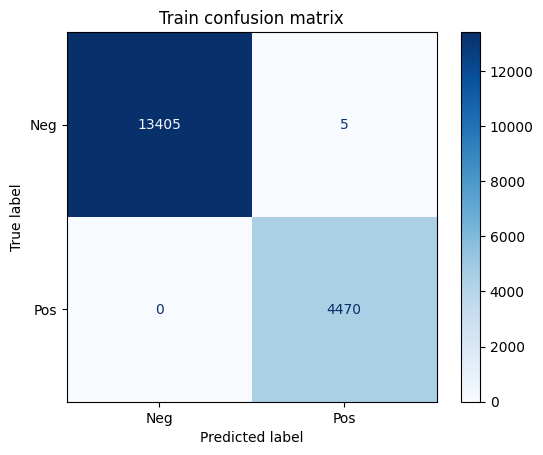

Validation metrics
  accuracy     0.777
  AUROC        0.572
  AUPRC        0.025
  precision    0.033
  recall       0.358
  specificity  0.785
  F1           0.060



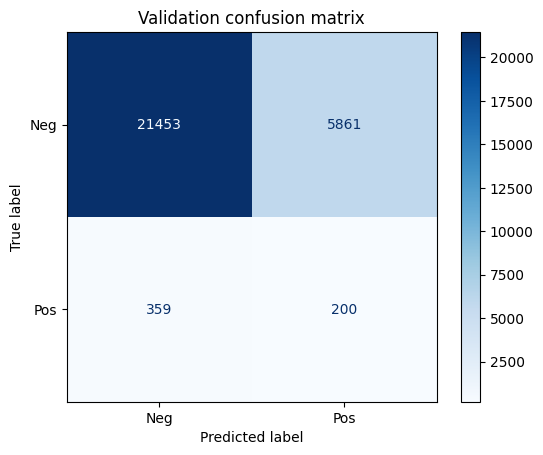

External test metrics
  accuracy     0.726
  AUROC        0.483
  AUPRC        0.068
  precision    0.060
  recall       0.201
  specificity  0.766
  F1           0.093



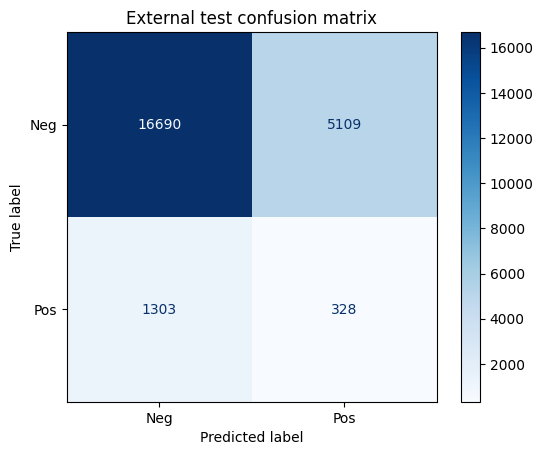

In [8]:
# Flatten datasets for evaluation
X_train_flat = X_train.reshape(len(X_train), -1)
X_val_flat = X_val.reshape(len(X_val), -1)
X_test_flat = X_test.reshape(len(X_test), -1)

# Report performance on train, validation, and external test sets
report('Train', X_train_flat, y_train)
report('Validation', X_val_flat, y_val)
report('External test', X_test_flat, y_test)

In [9]:
# 1-D feature matrices
X_train_flat, y_train, X_val_flat, y_val = (
    X_train.reshape(len(X_train), -1), y_train,
    X_val.reshape(len(X_val), -1), y_val
)

# Set up grid search for hyperparameter tuning
param_grid = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
}

# Create variable to store the best score and parameters
best_score, best_params, best_model = -1, None, None

# Perform grid search over the parameter grid
for params in ParameterGrid(param_grid):
    clf = DecisionTreeClassifier(
        **params,
        class_weight='balanced',
        random_state=RANDOM_STATE,
    )
    # Fit the classifier to the training data
    clf.fit(X_train_flat, y_train)

    # Validate the classifier on the validation set
    val_prob = clf.predict_proba(X_val_flat)[:, 1]

    # Calculate the AUROC score
    score = roc_auc_score(y_val, val_prob)

    # Update the best score and parameters if the current score is better
    if score > best_score:
        best_score, best_params, best_model = score, params, clf

# Print the best score and parameters
print(f'Best AUROC on val : {best_score:.3f}')
print(f'Best params       : {best_params}')

# Set the best model to the tree variable
tree = best_model

Best AUROC on val : 0.698
Best params       : {'max_depth': 5, 'min_samples_split': 2}


Train metrics
  accuracy     0.662
  AUROC        0.760
  AUPRC        0.466
  precision    0.405
  recall       0.755
  specificity  0.630
  F1           0.527



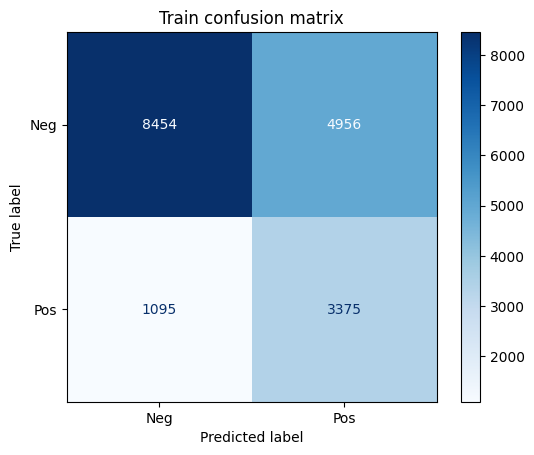

Validation metrics
  accuracy     0.598
  AUROC        0.698
  AUPRC        0.043
  precision    0.034
  recall       0.699
  specificity  0.596
  F1           0.065



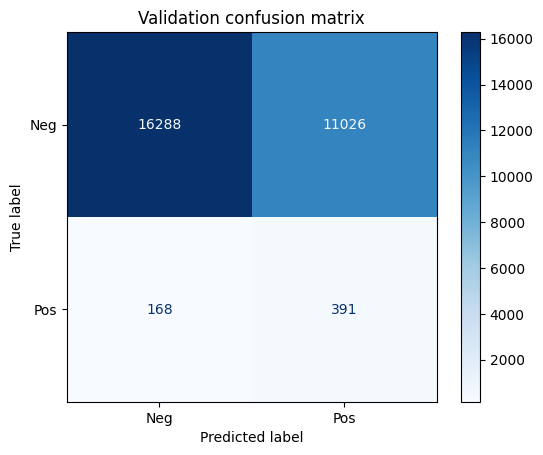

External test metrics
  accuracy     0.506
  AUROC        0.443
  AUPRC        0.065
  precision    0.059
  recall       0.408
  specificity  0.513
  F1           0.103



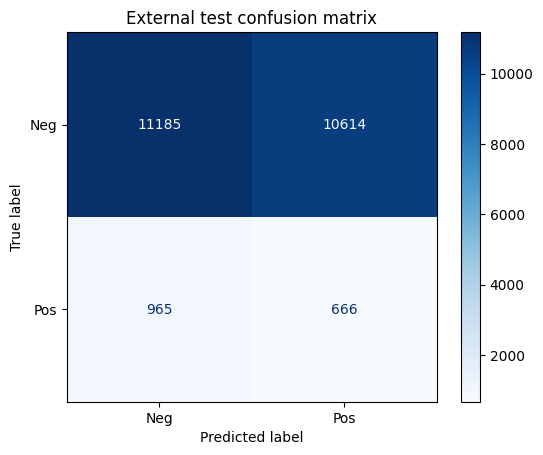

In [10]:
# Flatten datasets for evaluation
X_train_flat = X_train.reshape(len(X_train), -1)
X_val_flat = X_val.reshape(len(X_val), -1)
X_test_flat = X_test.reshape(len(X_test), -1)

# Report performance on train, validation, and external test sets
report('Train', X_train_flat, y_train)
report('Validation', X_val_flat, y_val)
report('External test', X_test_flat, y_test)

### Evaluation

In [ ]:
# Flatten datasets for evaluation
X_train_flat = X_train.reshape(len(X_train), -1)
X_val_flat = X_val.reshape(len(X_val), -1)
X_test_flat = X_test.reshape(len(X_test), -1)

# Report performance on train, validation, and external test sets
report('Train', X_train_flat, y_train)
report('Validation', X_val_flat, y_val)
report('External test', X_test_flat, y_test)

## Conclusion
Summarize baseline results and outline next steps for model improvements and deeper analyses.